In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, recall_score
from imblearn.over_sampling import SMOTE

from Models.model import *
from utils.utils import *
from utils.Visualization import *

import torch
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data_path = '../data/[24-2 DS_Project2] Data.csv'
df = pd.read_csv(data_path)

In [4]:
num_epochs = 100
batch_size = 128
lr = 1e-4

In [5]:
cat_features = ['Gender', 'Card Brand', 'Card Type', 'Expires', 'Has Chip', 'Year PIN last Changed', 'Whether Security Chip is Used', 'Day', 'Error Message']

num_features = ['Current Age', 'Retirement Age', 'Per Capita Income - Zipcode', 'Yearly Income', 'Total Debt', 'Credit Score', 'Credit Limit', 'Amount','Since Open Month']

discarded = ['User', 'Birth Year', 'Birth Month', 'Card', 'Card Number', 'Zipcode', 'Merchandise Code', 'Acct Open Date', 'Year', 'Month']

In [6]:
(train_cat_X, train_num_X, train_y), (valid_cat_X, valid_num_X, valid_y), label_encoders = dt_process_data(
    data_path,
    cat_features,
    num_features,
    discarded
)


TRANSITION
IQR
SPLIT
DISCARD
SCALE
ENCODE
TARGET
TRAIN CAT/NUM
VALID CAT/NUM
RETURN


In [7]:
smote = SMOTE(random_state=42, sampling_strategy=0.5)
train_X_resampled, train_y_resampled = smote.fit_resample(
    pd.concat([train_cat_X, train_num_X], axis=1), train_y['Is Fraud?']
)
# Resampled 데이터를 나누기
train_cat_X_resampled = train_X_resampled[cat_features]
train_num_X_resampled = train_X_resampled[num_features]
train_y_resampled = pd.DataFrame(train_y_resampled, columns=['Is Fraud?'])

In [8]:
print("Before SMOTE:", train_y['Is Fraud?'].value_counts())
print("After SMOTE:", train_y_resampled['Is Fraud?'].value_counts())


Before SMOTE: Is Fraud?
0.0    896343
1.0      1130
Name: count, dtype: int64
After SMOTE: Is Fraud?
0.0    896343
1.0     89634
Name: count, dtype: int64


In [9]:
class BaseDataset(Dataset):
    def __init__(self, cat_features, num_features, y, device):
        self.cat_features = torch.tensor(cat_features.values, dtype=torch.long).to(device)
        self.num_features = torch.tensor(num_features.values, dtype=torch.float).to(device)
        self.y = torch.tensor(y.values, dtype=torch.float).to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.cat_features[index], self.num_features[index], self.y[index]

In [10]:
train_dataset = BaseDataset(train_cat_X_resampled, train_num_X_resampled, y=train_y_resampled, device=device)
valid_dataset = BaseDataset(valid_cat_X, valid_num_X, y=valid_y, device=device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [11]:
#Base 모델 정의
encoding_dim = 28
l1_lambda = 0.001
pos_weight = torch.tensor([1 / 0.1]).to(device) #Fraud data에 가중치 10
model = BaseModel(encoding_dim, cat_features, num_features, 1).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [13]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    total_batches = 0

    train_preds = []
    train_labels = []

    # 학습
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        cat_x, num_x, y = batch

        optimizer.zero_grad()
        output = model(cat_x.to(device), num_x.to(device)).squeeze(1)
        y = y.view(-1)

        loss = criterion(output, y.to(device))
        l1_loss = 0
        for param in model.parameters():
            l1_loss += torch.abs(param).sum()

        #loss += l1_loss * l1_lambda

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        total_batches += 1

        preds = torch.sigmoid(output.detach()).cpu().numpy()
        preds = (preds > 0.5).astype(int)
        train_preds.extend(preds)
        train_labels.extend(y.cpu().numpy())

    # 평균 Loss 계산
    avg_epoch_loss = epoch_loss / total_batches

    # Training Metrics 계산
    train_accuracy = accuracy_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds, average='weighted')
    train_recall = recall_score(train_labels, train_preds, average='weighted')

    print(f"Epoch {epoch + 1}/{num_epochs} - Avg Train Loss: {avg_epoch_loss:.4f} - Train Acc: {train_accuracy:.4f} - Train F1: {train_f1:.4f} - Train Recall: {train_recall:.4f}")

    if (epoch+1) % 10 == 0:
        model.eval()
        valid_loss = 0
        total_batches = 0
        valid_preds = []
        valid_labels = []

        with torch.no_grad():
            for batch in tqdm(valid_loader, desc="Validation"):
                cat_x, num_x, y = batch

                output = model(cat_x.to(device), num_x.to(device)).squeeze(1)
                y = y.view(-1)

                loss = criterion(output, y.to(device))

                valid_loss += loss.item()
                total_batches += 1

                preds = torch.sigmoid(output.detach()).cpu().numpy()
                preds = (preds > 0.5).astype(int)
                valid_preds.extend(preds)
                valid_labels.extend(y.cpu().numpy())

        avg_valid_loss = valid_loss / total_batches

        # Validation Metrics 계산
        valid_accuracy = accuracy_score(valid_labels, valid_preds)
        valid_f1 = f1_score(valid_labels, valid_preds, average='weighted')
        valid_recall = recall_score(valid_labels, valid_preds, average='weighted')

        print(f"Epoch Validation - Avg Loss: {avg_valid_loss:.4f} - Acc: {valid_accuracy:.4f} - F1: {valid_f1:.4f} - Recall: {valid_recall:.4f}")
        print("Confusion Matrix:\n", confusion_matrix(valid_labels, valid_preds))

Epoch 1/100: 100%|██████████| 7703/7703 [00:36<00:00, 210.93it/s]


Epoch 1/100 - Avg Train Loss: 1.2603 - Train Acc: 0.3761 - Train F1: 0.4727 - Train Recall: 0.3761


Epoch 2/100: 100%|██████████| 7703/7703 [00:36<00:00, 213.08it/s]


Epoch 2/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5832 - Train F1: 0.6718 - Train Recall: 0.5832


Epoch 3/100: 100%|██████████| 7703/7703 [00:35<00:00, 219.12it/s]


Epoch 3/100 - Avg Train Loss: 1.2603 - Train Acc: 0.7055 - Train F1: 0.7599 - Train Recall: 0.7055


Epoch 4/100: 100%|██████████| 7703/7703 [00:35<00:00, 217.06it/s]


Epoch 4/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4016 - Train F1: 0.5015 - Train Recall: 0.4016


Epoch 5/100: 100%|██████████| 7703/7703 [00:34<00:00, 223.60it/s]


Epoch 5/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4265 - Train F1: 0.5282 - Train Recall: 0.4265


Epoch 6/100: 100%|██████████| 7703/7703 [00:38<00:00, 200.72it/s]


Epoch 6/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6607 - Train F1: 0.7297 - Train Recall: 0.6607


Epoch 7/100: 100%|██████████| 7703/7703 [00:33<00:00, 230.42it/s]


Epoch 7/100 - Avg Train Loss: 1.2603 - Train Acc: 0.3891 - Train F1: 0.4874 - Train Recall: 0.3891


Epoch 8/100: 100%|██████████| 7703/7703 [00:32<00:00, 234.88it/s]


Epoch 8/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6876 - Train F1: 0.7481 - Train Recall: 0.6876


Epoch 9/100: 100%|██████████| 7703/7703 [00:33<00:00, 232.43it/s]


Epoch 9/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4564 - Train F1: 0.5588 - Train Recall: 0.4564


Epoch 10/100: 100%|██████████| 7703/7703 [00:32<00:00, 237.99it/s]


Epoch 10/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5832 - Train F1: 0.6718 - Train Recall: 0.5832


Validation: 100%|██████████| 2396/2396 [00:03<00:00, 642.29it/s]


Epoch Validation - Avg Loss: 0.7040 - Acc: 0.0016 - F1: 0.0000 - Recall: 0.0016
Confusion Matrix:
 [[     0 306155]
 [     0    484]]


Epoch 11/100: 100%|██████████| 7703/7703 [00:33<00:00, 230.65it/s]


Epoch 11/100 - Avg Train Loss: 1.2603 - Train Acc: 0.3064 - Train F1: 0.3863 - Train Recall: 0.3064


Epoch 12/100: 100%|██████████| 7703/7703 [00:33<00:00, 231.60it/s]


Epoch 12/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5471 - Train F1: 0.6421 - Train Recall: 0.5471


Epoch 13/100: 100%|██████████| 7703/7703 [00:32<00:00, 234.01it/s]


Epoch 13/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4280 - Train F1: 0.5299 - Train Recall: 0.4280


Epoch 14/100: 100%|██████████| 7703/7703 [00:32<00:00, 235.34it/s]


Epoch 14/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4168 - Train F1: 0.5179 - Train Recall: 0.4168


Epoch 15/100: 100%|██████████| 7703/7703 [00:33<00:00, 230.60it/s]


Epoch 15/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5268 - Train F1: 0.6246 - Train Recall: 0.5268


Epoch 16/100: 100%|██████████| 7703/7703 [00:33<00:00, 229.79it/s]


Epoch 16/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4954 - Train F1: 0.5963 - Train Recall: 0.4954


Epoch 17/100: 100%|██████████| 7703/7703 [00:33<00:00, 231.37it/s]


Epoch 17/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6541 - Train F1: 0.7250 - Train Recall: 0.6541


Epoch 18/100: 100%|██████████| 7703/7703 [00:33<00:00, 232.13it/s]


Epoch 18/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4372 - Train F1: 0.5394 - Train Recall: 0.4372


Epoch 19/100: 100%|██████████| 7703/7703 [00:34<00:00, 225.65it/s]


Epoch 19/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5804 - Train F1: 0.6695 - Train Recall: 0.5804


Epoch 20/100: 100%|██████████| 7703/7703 [00:32<00:00, 234.34it/s]


Epoch 20/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5568 - Train F1: 0.6502 - Train Recall: 0.5568


Validation: 100%|██████████| 2396/2396 [00:03<00:00, 658.44it/s]


Epoch Validation - Avg Loss: 0.7043 - Acc: 0.0016 - F1: 0.0000 - Recall: 0.0016
Confusion Matrix:
 [[     0 306155]
 [     0    484]]


Epoch 21/100: 100%|██████████| 7703/7703 [00:33<00:00, 232.72it/s]


Epoch 21/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4256 - Train F1: 0.5273 - Train Recall: 0.4256


Epoch 22/100: 100%|██████████| 7703/7703 [00:32<00:00, 237.40it/s]


Epoch 22/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4181 - Train F1: 0.5194 - Train Recall: 0.4181


Epoch 23/100: 100%|██████████| 7703/7703 [00:33<00:00, 232.54it/s]


Epoch 23/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5388 - Train F1: 0.6350 - Train Recall: 0.5388


Epoch 24/100: 100%|██████████| 7703/7703 [00:32<00:00, 236.13it/s]


Epoch 24/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5127 - Train F1: 0.6121 - Train Recall: 0.5127


Epoch 25/100: 100%|██████████| 7703/7703 [00:33<00:00, 231.56it/s]


Epoch 25/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5769 - Train F1: 0.6667 - Train Recall: 0.5769


Epoch 26/100: 100%|██████████| 7703/7703 [00:33<00:00, 231.38it/s]


Epoch 26/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5676 - Train F1: 0.6591 - Train Recall: 0.5676


Epoch 27/100: 100%|██████████| 7703/7703 [00:32<00:00, 236.32it/s]


Epoch 27/100 - Avg Train Loss: 1.2603 - Train Acc: 0.3306 - Train F1: 0.4174 - Train Recall: 0.3306


Epoch 28/100: 100%|██████████| 7703/7703 [00:32<00:00, 237.83it/s]


Epoch 28/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6230 - Train F1: 0.7024 - Train Recall: 0.6230


Epoch 29/100: 100%|██████████| 7703/7703 [00:32<00:00, 234.39it/s]


Epoch 29/100 - Avg Train Loss: 1.2603 - Train Acc: 0.7517 - Train F1: 0.7888 - Train Recall: 0.7517


Epoch 30/100: 100%|██████████| 7703/7703 [00:32<00:00, 234.96it/s]


Epoch 30/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5181 - Train F1: 0.6169 - Train Recall: 0.5181


Validation: 100%|██████████| 2396/2396 [00:03<00:00, 672.07it/s]


Epoch Validation - Avg Loss: 0.7036 - Acc: 0.0016 - F1: 0.0000 - Recall: 0.0016
Confusion Matrix:
 [[     0 306155]
 [     0    484]]


Epoch 31/100: 100%|██████████| 7703/7703 [00:32<00:00, 234.65it/s]


Epoch 31/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4164 - Train F1: 0.5175 - Train Recall: 0.4164


Epoch 32/100: 100%|██████████| 7703/7703 [00:32<00:00, 236.97it/s]


Epoch 32/100 - Avg Train Loss: 1.2603 - Train Acc: 0.2572 - Train F1: 0.3170 - Train Recall: 0.2572


Epoch 33/100: 100%|██████████| 7703/7703 [00:32<00:00, 233.43it/s]


Epoch 33/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6352 - Train F1: 0.7114 - Train Recall: 0.6352


Epoch 34/100: 100%|██████████| 7703/7703 [00:32<00:00, 234.23it/s]


Epoch 34/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6844 - Train F1: 0.7459 - Train Recall: 0.6844


Epoch 35/100: 100%|██████████| 7703/7703 [00:33<00:00, 228.06it/s]


Epoch 35/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4602 - Train F1: 0.5627 - Train Recall: 0.4602


Epoch 36/100: 100%|██████████| 7703/7703 [00:33<00:00, 228.60it/s]


Epoch 36/100 - Avg Train Loss: 1.2603 - Train Acc: 0.3058 - Train F1: 0.3852 - Train Recall: 0.3058


Epoch 37/100: 100%|██████████| 7703/7703 [00:33<00:00, 232.57it/s]


Epoch 37/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6216 - Train F1: 0.7013 - Train Recall: 0.6216


Epoch 38/100: 100%|██████████| 7703/7703 [00:33<00:00, 227.54it/s]


Epoch 38/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6496 - Train F1: 0.7218 - Train Recall: 0.6496


Epoch 39/100: 100%|██████████| 7703/7703 [00:33<00:00, 226.75it/s]


Epoch 39/100 - Avg Train Loss: 1.2603 - Train Acc: 0.3402 - Train F1: 0.4296 - Train Recall: 0.3402


Epoch 40/100: 100%|██████████| 7703/7703 [00:32<00:00, 234.89it/s]


Epoch 40/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6407 - Train F1: 0.7154 - Train Recall: 0.6407


Validation: 100%|██████████| 2396/2396 [00:03<00:00, 629.98it/s]


Epoch Validation - Avg Loss: 0.7029 - Acc: 0.9984 - F1: 0.9976 - Recall: 0.9984
Confusion Matrix:
 [[306155      0]
 [   484      0]]


Epoch 41/100: 100%|██████████| 7703/7703 [00:34<00:00, 224.82it/s]


Epoch 41/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5899 - Train F1: 0.6771 - Train Recall: 0.5899


Epoch 42/100: 100%|██████████| 7703/7703 [00:29<00:00, 260.97it/s]


Epoch 42/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6040 - Train F1: 0.6880 - Train Recall: 0.6040


Epoch 43/100: 100%|██████████| 7703/7703 [00:30<00:00, 256.19it/s]


Epoch 43/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6323 - Train F1: 0.7093 - Train Recall: 0.6323


Epoch 44/100: 100%|██████████| 7703/7703 [00:34<00:00, 220.94it/s]


Epoch 44/100 - Avg Train Loss: 1.2603 - Train Acc: 0.2635 - Train F1: 0.3265 - Train Recall: 0.2635


Epoch 45/100: 100%|██████████| 7703/7703 [00:33<00:00, 230.57it/s]


Epoch 45/100 - Avg Train Loss: 1.2603 - Train Acc: 0.3687 - Train F1: 0.4640 - Train Recall: 0.3687


Epoch 46/100: 100%|██████████| 7703/7703 [00:39<00:00, 197.00it/s]


Epoch 46/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4678 - Train F1: 0.5701 - Train Recall: 0.4678


Epoch 47/100: 100%|██████████| 7703/7703 [00:36<00:00, 212.33it/s]


Epoch 47/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6349 - Train F1: 0.7112 - Train Recall: 0.6349


Epoch 48/100: 100%|██████████| 7703/7703 [00:36<00:00, 209.28it/s]


Epoch 48/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5259 - Train F1: 0.6238 - Train Recall: 0.5259


Epoch 49/100: 100%|██████████| 7703/7703 [00:36<00:00, 208.50it/s]


Epoch 49/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4411 - Train F1: 0.5434 - Train Recall: 0.4411


Epoch 50/100: 100%|██████████| 7703/7703 [00:36<00:00, 208.42it/s]


Epoch 50/100 - Avg Train Loss: 1.2603 - Train Acc: 0.2139 - Train F1: 0.2492 - Train Recall: 0.2139


Validation: 100%|██████████| 2396/2396 [00:03<00:00, 600.79it/s]


Epoch Validation - Avg Loss: 0.7005 - Acc: 0.9984 - F1: 0.9976 - Recall: 0.9984
Confusion Matrix:
 [[306155      0]
 [   484      0]]


Epoch 51/100: 100%|██████████| 7703/7703 [00:37<00:00, 206.01it/s]


Epoch 51/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6967 - Train F1: 0.7542 - Train Recall: 0.6967


Epoch 52/100: 100%|██████████| 7703/7703 [00:37<00:00, 207.46it/s]


Epoch 52/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4606 - Train F1: 0.5630 - Train Recall: 0.4606


Epoch 53/100: 100%|██████████| 7703/7703 [00:37<00:00, 206.64it/s]


Epoch 53/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6025 - Train F1: 0.6868 - Train Recall: 0.6025


Epoch 54/100: 100%|██████████| 7703/7703 [00:37<00:00, 205.76it/s]


Epoch 54/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4040 - Train F1: 0.5041 - Train Recall: 0.4040


Epoch 55/100: 100%|██████████| 7703/7703 [00:36<00:00, 210.23it/s]


Epoch 55/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4062 - Train F1: 0.5067 - Train Recall: 0.4062


Epoch 56/100: 100%|██████████| 7703/7703 [00:37<00:00, 203.05it/s]


Epoch 56/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6432 - Train F1: 0.7172 - Train Recall: 0.6432


Epoch 57/100: 100%|██████████| 7703/7703 [00:36<00:00, 209.67it/s]


Epoch 57/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4210 - Train F1: 0.5224 - Train Recall: 0.4210


Epoch 58/100: 100%|██████████| 7703/7703 [00:36<00:00, 208.28it/s]


Epoch 58/100 - Avg Train Loss: 1.2603 - Train Acc: 0.7991 - Train F1: 0.8160 - Train Recall: 0.7991


Epoch 59/100: 100%|██████████| 7703/7703 [00:36<00:00, 208.22it/s]


Epoch 59/100 - Avg Train Loss: 1.2603 - Train Acc: 0.3550 - Train F1: 0.4477 - Train Recall: 0.3550


Epoch 60/100: 100%|██████████| 7703/7703 [00:37<00:00, 206.70it/s]


Epoch 60/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4939 - Train F1: 0.5949 - Train Recall: 0.4939


Validation: 100%|██████████| 2396/2396 [00:03<00:00, 607.15it/s]


Epoch Validation - Avg Loss: 0.7032 - Acc: 0.0016 - F1: 0.0000 - Recall: 0.0016
Confusion Matrix:
 [[     0 306155]
 [     0    484]]


Epoch 61/100: 100%|██████████| 7703/7703 [00:36<00:00, 210.62it/s]


Epoch 61/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5603 - Train F1: 0.6531 - Train Recall: 0.5603


Epoch 62/100: 100%|██████████| 7703/7703 [00:36<00:00, 211.28it/s]


Epoch 62/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5880 - Train F1: 0.6756 - Train Recall: 0.5880


Epoch 63/100: 100%|██████████| 7703/7703 [00:36<00:00, 211.10it/s]


Epoch 63/100 - Avg Train Loss: 1.2603 - Train Acc: 0.3562 - Train F1: 0.4492 - Train Recall: 0.3562


Epoch 64/100: 100%|██████████| 7703/7703 [00:35<00:00, 214.98it/s]


Epoch 64/100 - Avg Train Loss: 1.2603 - Train Acc: 0.8375 - Train F1: 0.8361 - Train Recall: 0.8375


Epoch 65/100: 100%|██████████| 7703/7703 [00:35<00:00, 217.39it/s]


Epoch 65/100 - Avg Train Loss: 1.2603 - Train Acc: 0.3555 - Train F1: 0.4485 - Train Recall: 0.3555


Epoch 66/100: 100%|██████████| 7703/7703 [00:36<00:00, 213.08it/s]


Epoch 66/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4633 - Train F1: 0.5657 - Train Recall: 0.4633


Epoch 67/100: 100%|██████████| 7703/7703 [00:36<00:00, 213.40it/s]


Epoch 67/100 - Avg Train Loss: 1.2603 - Train Acc: 0.2536 - Train F1: 0.3114 - Train Recall: 0.2536


Epoch 68/100: 100%|██████████| 7703/7703 [00:35<00:00, 217.66it/s]


Epoch 68/100 - Avg Train Loss: 1.2603 - Train Acc: 0.7855 - Train F1: 0.8085 - Train Recall: 0.7855


Epoch 69/100: 100%|██████████| 7703/7703 [00:35<00:00, 219.68it/s]


Epoch 69/100 - Avg Train Loss: 1.2603 - Train Acc: 0.2099 - Train F1: 0.2426 - Train Recall: 0.2099


Epoch 70/100: 100%|██████████| 7703/7703 [00:35<00:00, 218.66it/s]


Epoch 70/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6673 - Train F1: 0.7343 - Train Recall: 0.6673


Validation: 100%|██████████| 2396/2396 [00:03<00:00, 651.11it/s]


Epoch Validation - Avg Loss: 0.7021 - Acc: 0.9984 - F1: 0.9976 - Recall: 0.9984
Confusion Matrix:
 [[306155      0]
 [   484      0]]


Epoch 71/100: 100%|██████████| 7703/7703 [00:35<00:00, 216.31it/s]


Epoch 71/100 - Avg Train Loss: 1.2603 - Train Acc: 0.7188 - Train F1: 0.7685 - Train Recall: 0.7188


Epoch 72/100: 100%|██████████| 7703/7703 [00:34<00:00, 220.51it/s]


Epoch 72/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4137 - Train F1: 0.5148 - Train Recall: 0.4137


Epoch 73/100: 100%|██████████| 7703/7703 [00:34<00:00, 223.61it/s]


Epoch 73/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4654 - Train F1: 0.5677 - Train Recall: 0.4654


Epoch 74/100: 100%|██████████| 7703/7703 [00:36<00:00, 210.21it/s]


Epoch 74/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4358 - Train F1: 0.5380 - Train Recall: 0.4358


Epoch 75/100: 100%|██████████| 7703/7703 [00:36<00:00, 212.25it/s]


Epoch 75/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5119 - Train F1: 0.6114 - Train Recall: 0.5119


Epoch 76/100: 100%|██████████| 7703/7703 [00:35<00:00, 214.13it/s]


Epoch 76/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4385 - Train F1: 0.5408 - Train Recall: 0.4385


Epoch 77/100: 100%|██████████| 7703/7703 [00:36<00:00, 211.11it/s]


Epoch 77/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4056 - Train F1: 0.5058 - Train Recall: 0.4056


Epoch 78/100: 100%|██████████| 7703/7703 [00:35<00:00, 215.23it/s]


Epoch 78/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6935 - Train F1: 0.7521 - Train Recall: 0.6935


Epoch 79/100: 100%|██████████| 7703/7703 [00:35<00:00, 214.16it/s]


Epoch 79/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5202 - Train F1: 0.6188 - Train Recall: 0.5202


Epoch 80/100: 100%|██████████| 7703/7703 [00:36<00:00, 212.19it/s]


Epoch 80/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4962 - Train F1: 0.5970 - Train Recall: 0.4962


Validation: 100%|██████████| 2396/2396 [00:03<00:00, 642.85it/s]


Epoch Validation - Avg Loss: 0.7043 - Acc: 0.0016 - F1: 0.0000 - Recall: 0.0016
Confusion Matrix:
 [[     0 306155]
 [     0    484]]


Epoch 81/100: 100%|██████████| 7703/7703 [00:36<00:00, 210.06it/s]


Epoch 81/100 - Avg Train Loss: 1.2603 - Train Acc: 0.3273 - Train F1: 0.4133 - Train Recall: 0.3273


Epoch 82/100: 100%|██████████| 7703/7703 [00:33<00:00, 231.70it/s]


Epoch 82/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6398 - Train F1: 0.7148 - Train Recall: 0.6398


Epoch 83/100: 100%|██████████| 7703/7703 [00:30<00:00, 250.61it/s]


Epoch 83/100 - Avg Train Loss: 1.2603 - Train Acc: 0.7508 - Train F1: 0.7883 - Train Recall: 0.7508


Epoch 84/100: 100%|██████████| 7703/7703 [00:35<00:00, 219.38it/s]


Epoch 84/100 - Avg Train Loss: 1.2603 - Train Acc: 0.3781 - Train F1: 0.4750 - Train Recall: 0.3781


Epoch 85/100: 100%|██████████| 7703/7703 [00:33<00:00, 227.60it/s]


Epoch 85/100 - Avg Train Loss: 1.2603 - Train Acc: 0.3612 - Train F1: 0.4552 - Train Recall: 0.3612


Epoch 86/100: 100%|██████████| 7703/7703 [00:33<00:00, 227.75it/s]


Epoch 86/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5905 - Train F1: 0.6775 - Train Recall: 0.5905


Epoch 87/100: 100%|██████████| 7703/7703 [00:36<00:00, 208.21it/s]


Epoch 87/100 - Avg Train Loss: 1.2603 - Train Acc: 0.3629 - Train F1: 0.4571 - Train Recall: 0.3629


Epoch 88/100: 100%|██████████| 7703/7703 [00:34<00:00, 221.21it/s]


Epoch 88/100 - Avg Train Loss: 1.2603 - Train Acc: 0.7455 - Train F1: 0.7850 - Train Recall: 0.7455


Epoch 89/100: 100%|██████████| 7703/7703 [00:33<00:00, 231.82it/s]


Epoch 89/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4922 - Train F1: 0.5933 - Train Recall: 0.4922


Epoch 90/100: 100%|██████████| 7703/7703 [00:32<00:00, 235.43it/s]


Epoch 90/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5637 - Train F1: 0.6559 - Train Recall: 0.5637


Validation: 100%|██████████| 2396/2396 [00:03<00:00, 669.27it/s]


Epoch Validation - Avg Loss: 0.7046 - Acc: 0.0016 - F1: 0.0000 - Recall: 0.0016
Confusion Matrix:
 [[     0 306155]
 [     0    484]]


Epoch 91/100: 100%|██████████| 7703/7703 [00:33<00:00, 230.25it/s]


Epoch 91/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4932 - Train F1: 0.5941 - Train Recall: 0.4932


Epoch 92/100: 100%|██████████| 7703/7703 [00:32<00:00, 240.26it/s]


Epoch 92/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4068 - Train F1: 0.5071 - Train Recall: 0.4068


Epoch 93/100: 100%|██████████| 7703/7703 [00:33<00:00, 232.67it/s]


Epoch 93/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4964 - Train F1: 0.5972 - Train Recall: 0.4964


Epoch 94/100: 100%|██████████| 7703/7703 [00:37<00:00, 205.12it/s]


Epoch 94/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4099 - Train F1: 0.5105 - Train Recall: 0.4099


Epoch 95/100: 100%|██████████| 7703/7703 [00:35<00:00, 214.34it/s]


Epoch 95/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5059 - Train F1: 0.6059 - Train Recall: 0.5059


Epoch 96/100: 100%|██████████| 7703/7703 [00:35<00:00, 215.78it/s]


Epoch 96/100 - Avg Train Loss: 1.2603 - Train Acc: 0.6576 - Train F1: 0.7275 - Train Recall: 0.6576


Epoch 97/100: 100%|██████████| 7703/7703 [00:34<00:00, 220.74it/s]


Epoch 97/100 - Avg Train Loss: 1.2603 - Train Acc: 0.7372 - Train F1: 0.7800 - Train Recall: 0.7372


Epoch 98/100: 100%|██████████| 7703/7703 [00:34<00:00, 221.18it/s]


Epoch 98/100 - Avg Train Loss: 1.2603 - Train Acc: 0.4736 - Train F1: 0.5757 - Train Recall: 0.4736


Epoch 99/100: 100%|██████████| 7703/7703 [00:35<00:00, 214.15it/s]


Epoch 99/100 - Avg Train Loss: 1.2603 - Train Acc: 0.3495 - Train F1: 0.4412 - Train Recall: 0.3495


Epoch 100/100: 100%|██████████| 7703/7703 [00:34<00:00, 223.11it/s]


Epoch 100/100 - Avg Train Loss: 1.2603 - Train Acc: 0.5210 - Train F1: 0.6195 - Train Recall: 0.5210


Validation: 100%|██████████| 2396/2396 [00:03<00:00, 614.72it/s]


Epoch Validation - Avg Loss: 0.7016 - Acc: 0.9984 - F1: 0.9976 - Recall: 0.9984
Confusion Matrix:
 [[306155      0]
 [   484      0]]


In [14]:
# Validation (모든 epoch 종료 후 실행)
model.eval()
valid_loss = 0
total_batches = 0
valid_preds = []
valid_labels = []

with torch.no_grad():
    for batch in tqdm(valid_loader, desc="Validation"):
        cat_x, num_x, y = batch

        output = model(cat_x.to(device), num_x.to(device)).squeeze(1)
        y = y.view(-1)

        loss = criterion(output, y.to(device))

        valid_loss += loss.item()
        total_batches += 1

        preds = torch.sigmoid(output.detach()).cpu().numpy()
        preds = (preds > 0.5).astype(int)
        valid_preds.extend(preds)
        valid_labels.extend(y.cpu().numpy())

avg_valid_loss = valid_loss / total_batches

# Validation Metrics 계산
valid_accuracy = accuracy_score(valid_labels, valid_preds)
valid_f1 = f1_score(valid_labels, valid_preds, average='weighted')
valid_recall = recall_score(valid_labels, valid_preds, average='weighted')

print(f"Final Validation - Avg Loss: {avg_valid_loss:.4f} - Acc: {valid_accuracy:.4f} - F1: {valid_f1:.4f} - Recall: {valid_recall:.4f}")


Validation: 100%|██████████| 2396/2396 [00:03<00:00, 681.78it/s]


Final Validation - Avg Loss: 0.7016 - Acc: 0.9984 - F1: 0.9976 - Recall: 0.9984


Confusion Matrix:
 [[306155      0]
 [   484      0]]


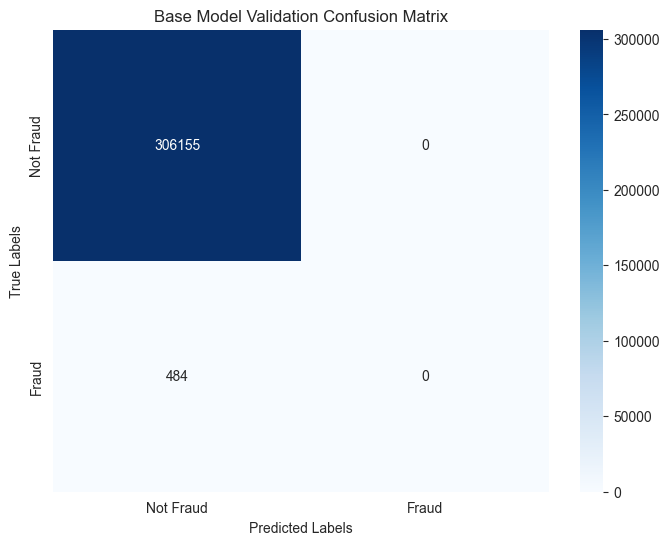

In [15]:
print("Confusion Matrix:\n", confusion_matrix(valid_labels, valid_preds))
plot_confusion_heatmap(
    y_true=valid_labels,
    y_pred=valid_preds,
    class_names=["Not Fraud", "Fraud"],
    title="Base Model Validation Confusion Matrix",
    cmap="Blues"
)

Confusion Matrix:
 [[     0 114890]
 [     0    182]]
